# Project Part 2 

Sam Sheridan, Karsyn Lee, Surya Pugal 

## (a)

In [1]:
import numpy as np

file=np.load("part2.npz")
beta_old=file['beta_old']
N=file['N']
Svc_0_PMF=file['Svc_0_PMF']
Lc=file['Lc']
Ic_0=file['Ic_0']
gamma=file['gamma']
L_observed=file['L_observed']
nb_nodes = Svc_0_PMF.shape[0]

In [2]:
def SIR(t, Z, N, betas, gamma):
    (S_vec, I_vec, R) = (Z[:16].reshape(4, 4), Z[16:20], Z[-1])
    I = I_vec.sum()
    dSdt = -betas*S_vec*I/N 
    dIdt = -dSdt.sum(axis=0)-gamma*I_vec
    dRdt = np.array([gamma*I])
    return np.concatenate((dSdt.flatten(), dIdt, dRdt))

In [3]:
from scipy.integrate import solve_ivp
from scipy.optimize import fmin
from sklearn.metrics import mean_squared_error

Svc_0_PMF /= Svc_0_PMF.sum(axis=(1, 2), keepdims=True)
Svc_0 = (N-Ic_0.sum(axis=1))[:, np.newaxis, np.newaxis]*Svc_0_PMF
Svc_0 = Svc_0.round().astype(int)
R0 = np.zeros((nb_nodes)).astype(int)

t = np.linspace(0, 199, 200)

S = np.zeros((nb_nodes, 4, 4, len(t)))
I = np.zeros((nb_nodes, 4, len(t)))
R = np.zeros((nb_nodes, len(t)))
L = np.zeros((nb_nodes, len(t)))

for N_node, node_index in zip(N, range(nb_nodes)):

    initial_conditions = np.concatenate(
        (Svc_0[node_index].flatten(), Ic_0[node_index], [R0[node_index]]))

    soln = solve_ivp(
        SIR, (t[0], t[9]), initial_conditions, args=(N_node, beta_old, gamma), t_eval=t[:10])

    S[node_index, :, :, :10] = soln.y[:16].reshape(4, 4, -1)
    I[node_index, :, :10] = soln.y[16:20]
    R[node_index, :10] = soln.y[20]
    L[node_index, :10] = Lc@soln.y[16:20]


alpha_predicted = np.zeros((nb_nodes))


def loss_func(alpha, N_node, node_index):
    
    initial_conditions = np.concatenate(
        (S[node_index, :, :, 9].flatten(), I[node_index, :, 9], [R[node_index, 9]]))
    
    beta = beta_old * alpha

    soln = solve_ivp(
        SIR, (t[10], t[29]), initial_conditions, args=(N_node, beta, gamma), t_eval=t[10:30])

    l_pred = Lc@soln.y[16:20]
    
    l_obs = L_observed[node_index, 10:30]
    
    mse = mean_squared_error(l_pred, l_obs)

    return mse


for N_node, node_index in zip(N, range(nb_nodes)):
    alpha_predicted[node_index] = fmin(loss_func, 0.5, disp=False, args=(N_node, node_index))


## (b)

In [4]:
def g(money):
    alpha = 1/np.log2(2*10**(-3)*money+2)
    return alpha

def g_inv(alpha):
    money = (2**(1/alpha)-2)/(2*10**(-3))
    return money

import matplotlib.pyplot as plt 
from tqdm import tqdm 

def scatter_plot(alpha_afterNPI):
    plt.figure()
    colors=(beta_old[np.newaxis,:,:]*Svc_0_PMF).mean(axis=(1,2))
    plt.scatter(alpha_predicted, alpha_afterNPI, s=N/500, c=colors, cmap='jet', alpha=0.5)
    plt.xlabel(r"$\alpha_{own}$")
    plt.ylabel(r"$\alpha_{after\ NPI}$")

def total_recovered_difference(alpha_afterNPI):

    R_npi = np.zeros((nb_nodes, len(t)))
    R_no_npi = np.zeros((nb_nodes, len(t)))

    for N_node, node_index in tqdm(zip(N, range(nb_nodes))):
        
        beta_npi = alpha_afterNPI[node_index] * beta_old
        beta_no_npi = alpha_predicted[node_index] * beta_old

        initial_conditions = np.concatenate(
            (S[node_index, :, :, 9].flatten(), I[node_index, :, 9], [R[node_index, 9]]))

        soln_npi = solve_ivp(
            SIR, (t[9], t[199]), initial_conditions, args=(N_node, beta_npi, gamma), t_eval=t[9:200])

        soln_no_npi = solve_ivp(
            SIR, (t[9], t[199]), initial_conditions, args=(N_node, beta_no_npi, gamma), t_eval=t[9:200])

        R_npi[node_index, 9:200] = soln_npi.y[20]
        R_no_npi[node_index, 9:200] = soln_no_npi.y[20]

    
    difference = R_no_npi[:, 199] - R_npi[:, 199] 
    

    return difference

### Policy #1

i.

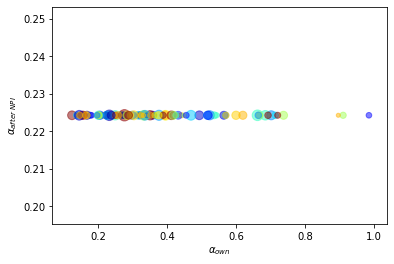

In [5]:
node_budget = 1000000/nb_nodes
alpha_after_even_budget = g(np.full(100, node_budget))
scatter_plot(alpha_after_even_budget)

In [6]:
even_budget_diff = total_recovered_difference(alpha_after_even_budget)
even_budget_total_diff = sum(even_budget_diff)

100it [00:00, 132.16it/s]


In [7]:
print(f" There were {even_budget_total_diff:.0f} total fewer people who recovered/succumbed to covid after NPI")

 There were 511743 total fewer people who recovered/succumbed to covid after NPI


ii.

### Policy #2

i. 

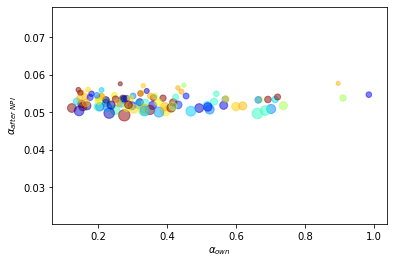

In [8]:
node_budget = np.array([n / len(N) for n in N]) * 1000000
alpha_after = g(node_budget)
scatter_plot(alpha_after)

ii.

In [9]:
prop_budget_diff = total_recovered_difference(alpha_after)
prop_budget_total_diff = sum(prop_budget_diff)

100it [00:00, 117.69it/s]


In [10]:
print(f" There were {prop_budget_total_diff:.0f} total fewer people who recovered/succumbed to covid after NPI")

 There were 1118251 total fewer people who recovered/succumbed to covid after NPI


### Policy #3

In [11]:
def delta_alpha(da):
    budget = g_inv(alpha_predicted + da)
    return np.abs(sum(budget) - 1000000)

In [12]:
change_in_alpha = fmin(delta_alpha, 0, disp=False)    

In [13]:
delta_a = change_in_alpha[0]
print(delta_a)

0.003567813336849214


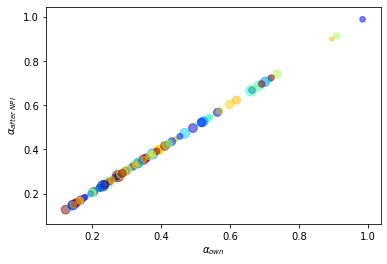

In [14]:
alpha_equal_change = alpha_predicted + delta_a
scatter_plot(alpha_equal_change)

i.

In [15]:
delta_alpha_budget_diff = total_recovered_difference(alpha_equal_change)
delta_alpha_budget_total_diff = sum(delta_alpha_budget_diff)

100it [00:00, 115.85it/s]


In [16]:
print(f" There were {delta_alpha_budget_total_diff:.0f} total fewer people who recovered/succumbed to covid after NPI")

 There were -11253 total fewer people who recovered/succumbed to covid after NPI


ii.

### Policy #4

Spend the budget proportional to each node's average beta value weighted by the susceptible
population size in comorbidity and vulnerability compartments

In [101]:
prop_beta = [np.sum(S[node_index, :, :, 9] * beta_old) / np.sum(S[:, :, :, 9] * beta_old) for node_index in range(nb_nodes)] 

In [102]:
nb_nodes

100

In [106]:
prop_beta = np.array(prop_beta) * 1000000

In [107]:
alpha_prop_beta = g(prop_beta)

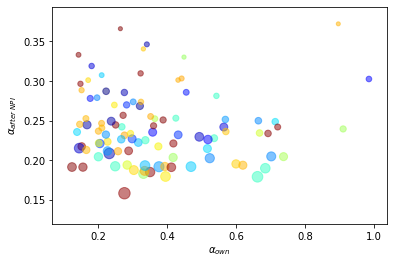

In [109]:
scatter_plot(alpha_prop_beta)

In [110]:
prop_beta_diff = total_recovered_difference(alpha_prop_beta)
prob_beta_total_diff = sum(prop_beta_diff)

100it [00:00, 129.31it/s]


In [111]:
print(f" There were {prob_beta_total_diff:.0f} total fewer people who recovered/succumbed to covid after NPI")

 There were 555209 total fewer people who recovered/succumbed to covid after NPI


ii.

## (c)

### Policy 1

### Policy 2

### Policy 3

### Policy 4